# Colorization Network

## Imports

In [1]:
import os
import math
import random
import shutil

import cv2

import PIL

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.color import lab2rgb, rgb2lab
from skimage import io

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset

from ignite.engine import Events, Engine
from ignite.metrics import Accuracy, Loss
from ignite.handlers import EarlyStopping

from CustomData import ImageDataset

In [2]:
torch.set_default_tensor_type('torch.FloatTensor')

## Define Dataset

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

transformed_train_dataset = ImageDataset(root_dir='./TrainSet',
                                         transform=transform,
                                         regressor_only=False)
transformed_test_dataset = ImageDataset(root_dir='./TestSet',
                                        transform=transform,
                                        regressor_only=False)
transformed_val_dataset = ImageDataset(root_dir='./ValSet',
                                       transform=transform,
                                       regressor_only=False)

## Train/Test Split

In [4]:
batch_size = 8

trainloader = torch.utils.data.DataLoader(transformed_train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(transformed_test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)
valloader = torch.utils.data.DataLoader(transformed_val_dataset, batch_size=batch_size,
                                        shuffle=True, num_workers=0)

## Plot some images

In [5]:
def imshow(img):
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    npimg = npimg.astype('float32')
    plt.imshow(npimg)
    plt.show()

In [6]:
# get some random training images
dataiter = iter(trainloader)
images_gray, images_color, images_ab = dataiter.next()

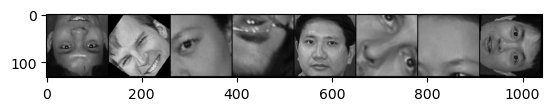

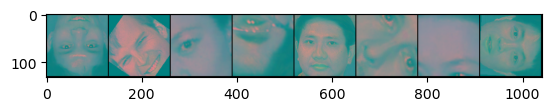

In [7]:
# show some images
imshow(torchvision.utils.make_grid(images_gray))
imshow(torchvision.utils.make_grid(images_color))

## Function for concating L and AB channels

In [8]:
def cat_l_ab(images_gray, images_ab):
    return torch.cat((images_gray, images_ab), 1)

## Define network

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.downsample = nn.Sequential(
            nn.Conv2d(1, 8, 3, 2, 1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 32, 3, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(128, 32, 2, 2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 8, 2, 2),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 2, 2, 2),
            nn.ReLU()
            #nn.Tanh()
        )

    def forward(self, x):
        midlevel = self.downsample(x)
        output = self.upsample(midlevel)
        return output

net = Net()

### Move to cuda if possible

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
print(device)

cuda:0


## Define optimizer

In [11]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-2, weight_decay=0.0)

## Train

In [12]:
epoch_history = {'1': []}
num_mini_batch_print = 50

def train_step(engine, batch):
    # get the inputs; data is a list of [inputs, labels]
    images_gray, images_color, images_ab = batch[0].to(device), batch[1].to(device), batch[2].to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(images_gray)
    loss = criterion(outputs, images_ab)
    loss.backward()
    optimizer.step()

    return loss.item()

trainer = Engine(train_step)

def validation_step(engine, batch):
    with torch.no_grad():
        # get the inputs; data is a list of [inputs, labels]
        images_gray, images_color, images_ab = batch[0].to(device), batch[1].to(device), batch[2].to(device)

        # forward
        outputs = net(images_gray)
        outputs = cat_l_ab(images_gray, outputs)

        return outputs, images_color

evaluator = Engine(validation_step)
metric = Loss(criterion)
metric.attach(evaluator, 'mse')

@trainer.on(Events.ITERATION_COMPLETED(every=num_mini_batch_print))
def log_training_loss(trainer):
    global epoch_history
    epoch_history[f'{trainer.state.epoch}'].append(trainer.state.output)
    print(f"Epoch[{trainer.state.epoch}] Loss: {trainer.state.output:.5f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    global epoch_history
    epoch_history[f'{trainer.state.epoch + 1 }'] = []
    evaluator.run(trainloader)
    metrics = evaluator.state.metrics
    print(f"Training Results - Epoch: {trainer.state.epoch}  Avg loss: {metrics['mse']:.5f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(valloader)
    metrics = evaluator.state.metrics
    print(f"Validation Results - Epoch: {trainer.state.epoch}  Avg loss: {metrics['mse']:.5f}")

def score_function(engine):
    val_loss = engine.state.metrics['mse']
    return -val_loss

handler = EarlyStopping(patience=5, score_function=score_function, trainer=trainer)
# Note: the handler is attached to an *Evaluator* (runs one epoch on validation dataset).
evaluator.add_event_handler(Events.COMPLETED, handler)

trainer.run(trainloader, max_epochs=20)

Epoch[1] Loss: 0.00176
Epoch[1] Loss: 0.00044
Epoch[1] Loss: 0.00040
Epoch[1] Loss: 0.00042
Epoch[1] Loss: 0.00052
Epoch[1] Loss: 0.00057
Epoch[1] Loss: 0.00034
Epoch[1] Loss: 0.00041
Epoch[1] Loss: 0.00037
Epoch[1] Loss: 0.00046
Epoch[1] Loss: 0.00051
Epoch[1] Loss: 0.00038
Epoch[1] Loss: 0.00046
Epoch[1] Loss: 0.00045
Epoch[1] Loss: 0.00049
Epoch[1] Loss: 0.00029
Training Results - Epoch: 1  Avg loss: 0.00025
Validation Results - Epoch: 1  Avg loss: 0.00032
Epoch[2] Loss: 0.00043
Epoch[2] Loss: 0.00053
Epoch[2] Loss: 0.00050
Epoch[2] Loss: 0.00025
Epoch[2] Loss: 0.00036
Epoch[2] Loss: 0.00064
Epoch[2] Loss: 0.00034
Epoch[2] Loss: 0.00033
Epoch[2] Loss: 0.00033
Epoch[2] Loss: 0.00039
Epoch[2] Loss: 0.00045
Epoch[2] Loss: 0.00025
Epoch[2] Loss: 0.00039
Epoch[2] Loss: 0.00040
Epoch[2] Loss: 0.00037
Epoch[2] Loss: 0.00047
Epoch[2] Loss: 0.00034
Training Results - Epoch: 2  Avg loss: 0.00024
Validation Results - Epoch: 2  Avg loss: 0.00030
Epoch[3] Loss: 0.00041
Epoch[3] Loss: 0.00062
Epo

2021-10-25 04:56:13,431 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Training Results - Epoch: 4  Avg loss: 0.00025
Validation Results - Epoch: 4  Avg loss: 0.00033


State:
	iteration: 3376
	epoch: 4
	epoch_length: 844
	max_epochs: 20
	output: 0.00034919657628051937
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

## Plot results of each epoch vs loss

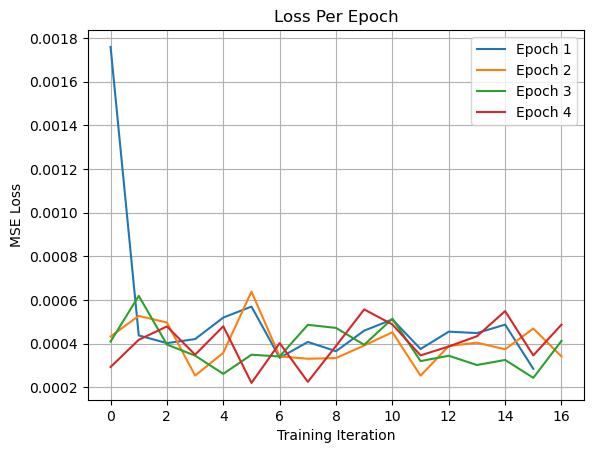

In [13]:
for i in range(1, len(epoch_history)):
    plt.plot(range(len(epoch_history[f'{i}'])), epoch_history[f'{i}'], label=f'Epoch {i}')

plt.legend(loc="upper right")
plt.xlabel('Training Iteration')
plt.ylabel('MSE Loss')
plt.title('Loss Per Epoch')
plt.grid(True)
plt.show()

## Save Model

In [14]:
PATH = './colorize_net.pth'
torch.save(net.state_dict(), PATH)

## Evaluate Model
### Peak at 4 test examples

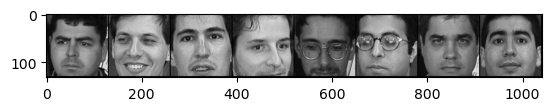

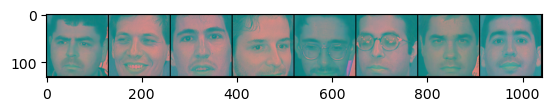

In [15]:
dataiter = iter(testloader)
images_gray, images_color, images_ab = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images_gray))
imshow(torchvision.utils.make_grid(images_color))

### Look at model performance on these examples

In [16]:
outputs = net(images_gray.to(device)).cpu()

### Combine l, a and b channels

In [17]:
outputs = cat_l_ab(images_gray, outputs)

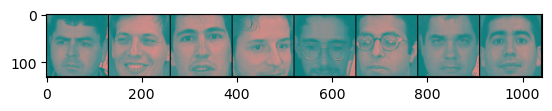

In [18]:
imshow(torchvision.utils.make_grid(outputs))

## Convert Tensor output to RGB

In [19]:
def tensor_to_rgb(tensors):
    images_RGB = []

    for tensor in tensors:
        color_image = tensor.detach().clone().numpy()
        color_image = np.transpose(color_image, (1,2,0))
        color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
        color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
        color_image = lab2rgb(color_image.astype(np.float64))
        color_image = np.transpose(color_image, (2,0,1))
        images_RGB.append(color_image)

    return torch.tensor(np.array(images_RGB))

Input:


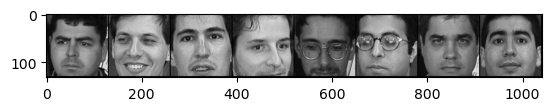

Ground truth:


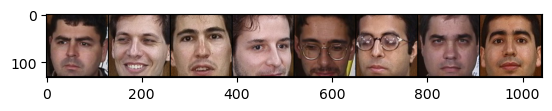

Colorize Net outputs:


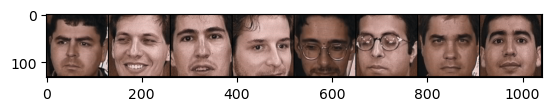

MSE loss for each image:

0.00012	0.00012	0.00018	0.00011	0.00029	0.00022	0.00023	0.00069


In [20]:
print('Input:')
imshow(torchvision.utils.make_grid(images_gray))
print('Ground truth:')
imshow(torchvision.utils.make_grid(tensor_to_rgb(images_color)))
print('Colorize Net outputs:')
imshow(torchvision.utils.make_grid(tensor_to_rgb(outputs)))

# Also show MSE loss for each image
test_batch_losses = []

for i, output in enumerate(outputs):
    test_batch_losses.append(f'{criterion(output, images_color[i]).tolist():.5f}')

print("MSE loss for each image:\n")
print(*test_batch_losses, sep = "\t") 

## Evaluate performance on whole test set

In [21]:
# Create empty output directory
output_dir = './Output'

if os.path.exists(output_dir):
    shutil.rmtree(output_dir)

os.makedirs(output_dir)

In [ ]:
test_loss = []

with torch.no_grad():
    for i, data in enumerate(testloader):
        # get the inputs; data is a list of [inputs, labels]
        images_gray, images_color, images_ab = data[0].to(device), data[1].to(device), data[2].to(device)

        # forward + backward + optimize
        outputs = net(images_gray)
        outputs = torch.cat((images_gray, outputs), 1)
        
        rgb_outputs = tensor_to_rgb(outputs.cpu())
        
        for j in range(outputs.shape[0]):
            loss = criterion(outputs[j], images_color[j])
            test_loss.append(loss)
            
            # Save images
            img_idx = (i * batch_size) + j
            img_path = os.path.join(output_dir, transformed_test_dataset.image_paths[img_idx])
            img_data = torch.permute(rgb_outputs[j], (1, 2, 0)).numpy()
            io.imsave(img_path, img_data)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

In [ ]:
print(f'Average test loss: {torch.mean(torch.tensor(test_loss))}')